In [55]:
import os
import glob
import joblib
import datetime
import pandas as pd
import numpy as np
import json
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]
%matplotlib inline

## Ideal Data

Business scenario - Is the ala carte approach better in revenue generation?

What kind of data do we need?
- How to predict revenue for a specific country for the following month?
- Revenue per country by month
- Such that the model can learn all the factors that influence monthly revenue
- Datasets probably need to be split by country

## Load and Pre-process Data

What is the data?
- Transaction level purchases across 38 countries
- Limit top ten countries by revenue

In [2]:
DATA_ROOT = Path('data')
RAW_DATA_ROOT = DATA_ROOT / 'cs-train'

In [3]:
# read json files into single dataframe and rename columns for into standard naming
data_list = []
for json_file in glob.glob(str(TRAIN_ROOT / '*.json')):
    with open(json_file, 'r') as f:
        data = json.load(f)
        data_df = pd.DataFrame(data)
        data_df.rename(columns={'StreamID':'stream_id','TimesViewed':'times_viewed','total_price':'price'},inplace=True)
        data_list.append(data_df)

In [4]:
df = pd.concat(data_list)

In [5]:
df.describe()

,customer_id,price,times_viewed
count,625249.000000,815011.000000,815011.000000
mean,15333.415068,4.802631,5.231106
std,1698.360788,135.058707,5.109982
min,12346.000000,-53594.360000,0.000000
25%,13956.000000,1.250000,1.000000
50%,15279.000000,2.100000,3.000000
75%,16813.000000,4.210000,8.000000
max,18287.000000,38970.000000,24.000000


In [76]:
# combine year month day columns into single datetime datatype column
df['date'] = df.apply(lambda row: datetime.datetime(int(row.year), int(row.month), int(row.day)),axis=1)

df.invoice = df.invoice.str.replace('\D+','')

# filter top 10 countries
top_countries = df.groupby('country').price.sum().sort_values(ascending=False)[:10].index
dft = df[df.country.isin(top_countries)]

C:\Users\shenghan\AppData\Local\Temp/ipykernel_21444/2666419126.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.invoice = df.invoice.str.replace('\D+','')


In [77]:
# view snapshot of dataset
dft.head()

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,date
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28,2017-11-28
1,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28,2017-11-28
2,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28,2017-11-28
3,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28,2017-11-28
4,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28,2017-11-28


## Analyze Data

Summary:
- Price dataset contains outliers and negative values, which will need to be clarified with business
- customer_id has 23% missing values, but we won't be using this 
- Revenue and transactions wise, viewers from the UK generated most revenue by a large margin compared to viewers from other countries. This large difference probably warrants a separate model for each country.
- Countries with least transactions in the top 10 by revenue: Norway, Singapore and Hong Kong have rather sparse time series data and may not contain enough trend or seasonality information to model on

<AxesSubplot:>

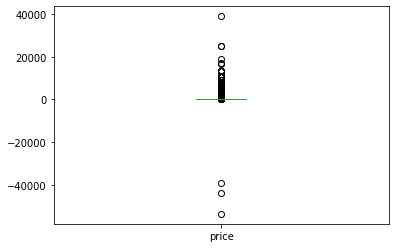

In [85]:
# observe distribution of pricing per transaction
# why are there negative prices?
dft.price.plot.box()

In [208]:
# why are these negative. what does stream_id = B mean?
dft[dft.price < 0]

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,date
29648,United Kingdom,NaN,A506401,-53594.36,B,1,2018,04,26,2018-04-26
16895,United Kingdom,NaN,A516228,-44031.79,B,1,2018,07,16,2018-07-16
34579,United Kingdom,NaN,A528059,-38925.87,B,1,2018,10,17,2018-10-17


<AxesSubplot:>

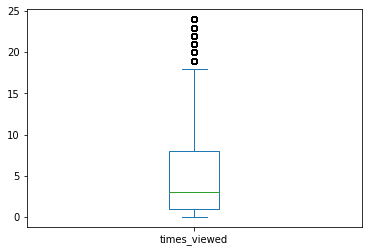

In [86]:
# distribution of times viewed 
dft.times_viewed.plot.box()

In [87]:
# percentage missing per feature - only customer_id has missing data - 23.7%
dft.isnull().sum() / len(dft) * 100

country          0.000000
customer_id     23.723503
invoice          0.000000
price            0.000000
stream_id        0.000000
times_viewed     0.000000
year             0.000000
month            0.000000
day              0.000000
date             0.000000
dtype: float64

In [88]:
# transactions by country
dft.country.value_counts()

United Kingdom    751228
EIRE               13577
Germany            13336
France              9899
Netherlands         4024
Spain               2606
Portugal            1815
Norway               796
Singapore            310
Hong Kong            276
Name: country, dtype: int64

In [133]:
# revenue by country - used this to filter top 10 countries by revenue
dft.groupby('country').price.sum().sort_values(ascending=False)

country
United Kingdom    3521513.505
EIRE               107069.210
Germany             49271.821
France              40565.140
Norway              38494.750
Spain               16040.990
Hong Kong           14452.570
Portugal            13528.670
Singapore           13175.920
Netherlands         12322.800
Name: price, dtype: float64

In [89]:
dft.customer_id.nunique()

5027

In [90]:
dft.invoice.nunique()

41702

## Convert dataset to timeseries

In [63]:
# create day range from first ot last day in dataset
day_range = pd.date_range(dft.date.min(), dft.date.max())

Text(0.5, 1.0, 'Purchases by country')

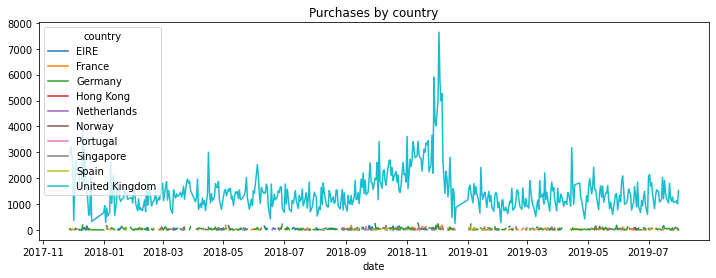

In [246]:
fig, axs = plt.subplots(figsize=(12, 4))
dft.groupby(['country', dft.date.dt.date]).size().unstack(0).plot(ax=axs)
plt.title('Purchases by country')

Text(0.5, 1.0, 'Purchases by country (excl. UK)')

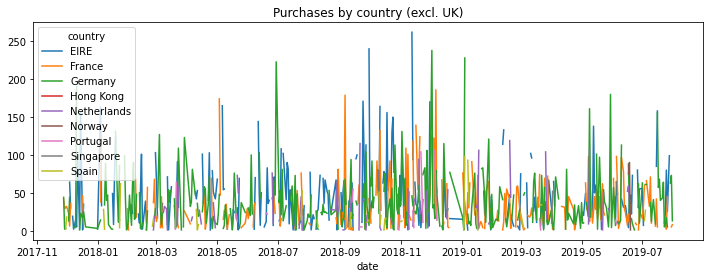

In [247]:
# removing UK since it's dominating the plot so we can uncover the trends of other countries
fig, axs = plt.subplots(figsize=(12, 4))
dft[dft.country != 'United Kingdom'].groupby(['country', dft[dft.country != 'United Kingdom'].date.dt.date]).size().unstack(0).plot(ax=axs)
plt.title('Purchases by country (excl. UK)')

Text(0.5, 1.0, 'Daily Invoices by country')

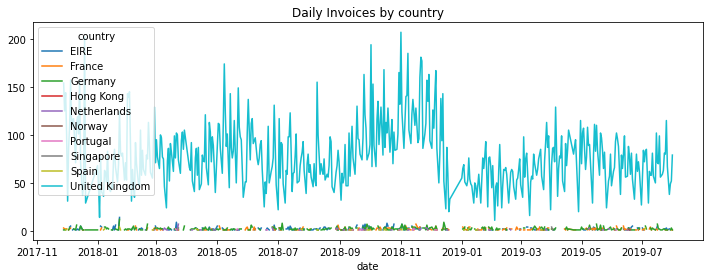

In [248]:
fig, axs = plt.subplots(figsize=(12, 4))
dft.groupby(['country', dft.date.dt.date]).invoice.nunique().unstack(0).plot(ax=axs)
plt.title('Daily Invoices by country')

Text(0.5, 1.0, 'Daily Streams by country')

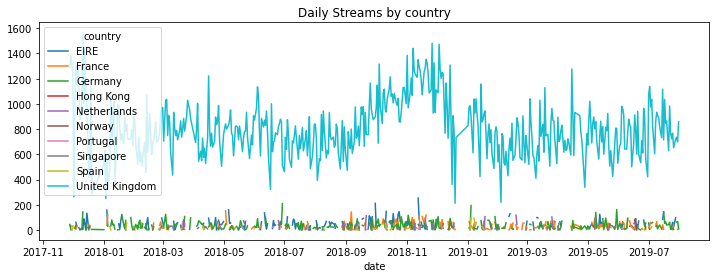

In [225]:
fig, axs = plt.subplots(figsize=(12, 4))
dft.groupby(['country', dft.date.dt.date]).stream_id.nunique().unstack(0).plot(ax=axs)
plt.title('Daily Streams by country')

Text(0.5, 1.0, 'Daily Views by country')

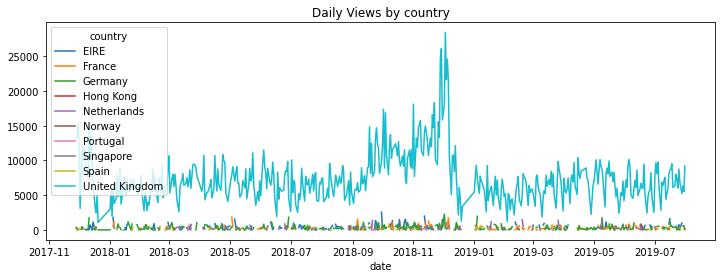

In [226]:
fig, axs = plt.subplots(figsize=(12, 4))
dft.groupby(['country', dft.date.dt.date]).times_viewed.sum().unstack(0).plot(ax=axs)
plt.title('Daily Views by country')

Text(0.5, 1.0, 'Daily Views by country (excl. UK)')

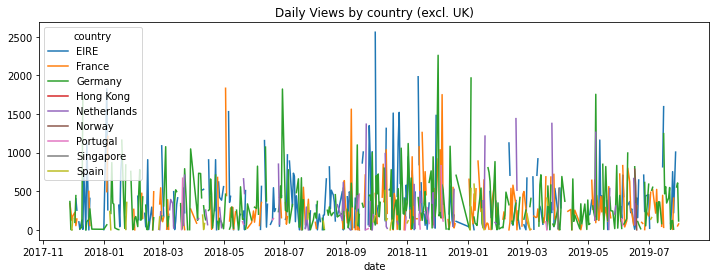

In [150]:
# again, removing UK since it's dominating the plot so we can uncover the trends of other countries
fig, axs = plt.subplots(figsize=(12, 4))
dft[dft.country != 'United Kingdom'].groupby(['country', dft[dft.country != 'United Kingdom'].date.dt.date]).times_viewed.sum().unstack(0).plot(ax=axs)
plt.title('Daily Views by country (excl. UK)')

Text(0.5, 1.0, 'Daily Revenue by country')

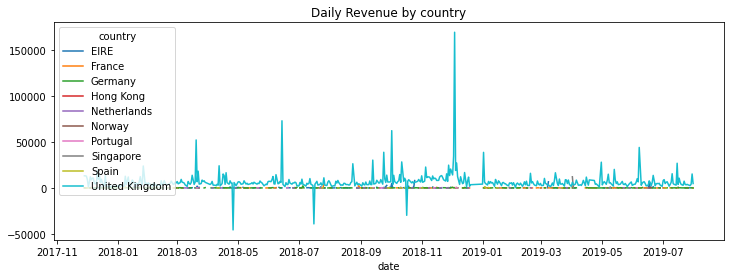

In [227]:
fig, axs = plt.subplots(figsize=(12, 4))
dft.groupby(['country', dft.date.dt.date]).price.sum().unstack(0).plot(ax=axs)
plt.title('Daily Revenue by country')

In [130]:
# create summarized timeseries dataset for each day

countries = {}
for country in dft.country.unique().tolist() + ['all']:
    dftc = dft if country == 'all' else dft[dft.country == country]
    purchases, invoices, streams, views, revenue = [], [], [], [], []
    for day in day_range:
        rec = dftc[dftc.date == day]
        purchases.append(len(rec))
        invoices.append(rec.invoice.nunique())
        streams.append(rec.stream_id.nunique())
        views.append(rec.times_viewed.sum())
        revenue.append(rec.price.sum())
        
    df_daily = pd.DataFrame({'date':day_range,
                            'purchases':purchases,
                            'invoices':invoices,
                            'streams':streams,
                            'views':views,
                            'revenue':revenue})
    df_daily.set_index('date',inplace=True)
    df_daily['year_month'] = df_daily.index.to_period('M')

    countries[country] = df_daily

In [132]:
dft_all = countries['all']

Text(0.5, 1.0, 'Total Purchases')

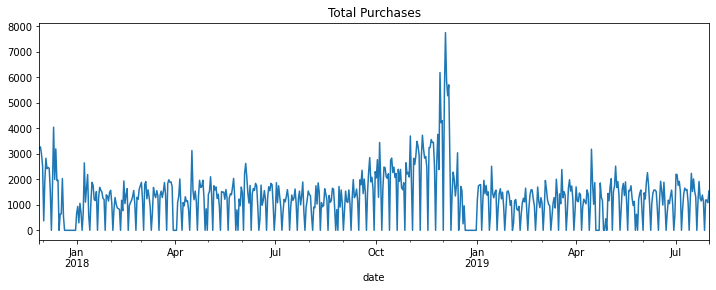

In [141]:
fig, axs = plt.subplots(figsize=(12, 4))
dft_all.purchases.plot(ax=axs)
plt.title('Total Purchases')

Text(0.5, 1.0, 'Total Purchases (Singapore)')

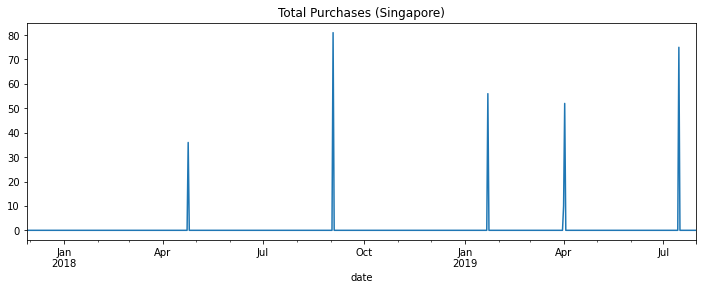

In [143]:
fig, axs = plt.subplots(figsize=(12, 4))
countries['Singapore'].purchases.plot(ax=axs)
plt.title('Total Purchases (Singapore)')

## Feature Engineering

Predict the next point in timeseries of monthly revenue

Supervised approach
- Label - Monthly revenue
- Input - Country + Input dataset

New features:
- I've decided to take the guidance to derive rolling features of past day, week, 2,3,4,8,12-weeks and past year that may capture the seasonality
- Also added non revenue features such as number of invoices and views for a 30 day period

Prediction:
- These 10 features can be aggregated from production data and fed into the model as inputs to the trained model

In [199]:
# take UK timeseries data
df_uk = countries['United Kingdom']

In [200]:
df_uk.tail()

,purchases,invoices,streams,views,revenue,year_month
date,,,,,,
2019-07-27,0,0,0,0,0.00,2019-07
2019-07-28,1093,38,721,5220,2656.70,2019-07
2019-07-29,1124,49,735,6324,4124.82,2019-07
2019-07-30,1007,52,699,5495,15260.12,2019-07
2019-07-31,1522,79,858,9187,4844.04,2019-07


In [105]:
# create features of revenue
# for each day in timeseries, create rolling past day, past week, past n day revenue
features_list = []
for date, row in df_uk.iterrows():
    past_n_days = [1, 7, 14, 21, 28, 56, 84]
    new_feature = {}
    for past_n in past_n_days:
        new_feature[f'prev_{past_n}'] = df_uk[date-datetime.timedelta(days=past_n):date].revenue.sum()
        
    # label - revenue for the month
    new_feature['revenue'] = df_uk[date:date+datetime.timedelta(days=30)].revenue.sum()
    
    # previous year
    new_feature['prev_year'] = df_uk[date - datetime.timedelta(days=365):date - datetime.timedelta(days=335)].revenue.sum()
    
    new_feature['invoices'] = df_uk[date - datetime.timedelta(days=30):date].invoices.mean()
    new_feature['views'] = df_uk[date - datetime.timedelta(days=30):date].views.mean()
        
    features_list.append(new_feature)

In [201]:
dfn = pd.DataFrame(features_list, index=df_uk.index)
dfn.head()

,prev_1,prev_7,prev_14,prev_21,prev_28,prev_56,prev_84,revenue,prev_year,invoices,views
date,,,,,,,,,,,
2017-11-28,13281.12,13281.12,13281.12,13281.12,13281.12,13281.12,13281.12,187241.07,0.0,154.00,12922.000000
2017-11-29,26504.09,26504.09,26504.09,26504.09,26504.09,26504.09,26504.09,173959.95,0.0,139.50,13286.000000
2017-11-30,26164.47,39445.59,39445.59,39445.59,39445.59,39445.59,39445.59,160736.98,0.0,141.00,13938.333333
2017-12-01,22104.57,48608.66,48608.66,48608.66,48608.66,48608.66,48608.66,147795.48,0.0,130.75,13366.750000
2017-12-02,10426.35,49871.94,49871.94,49871.94,49871.94,49871.94,49871.94,140568.67,0.0,110.80,11313.600000


Text(0.5, 1.0, 'New featueres')

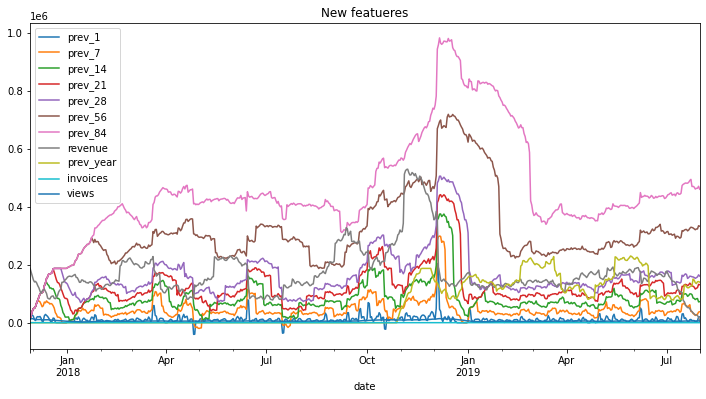

In [107]:
fig, axs = plt.subplots(figsize=(12, 6))
dfn.plot(ax=axs)
plt.title('New featueres')

Text(0.5, 1.0, 'Average invoices')

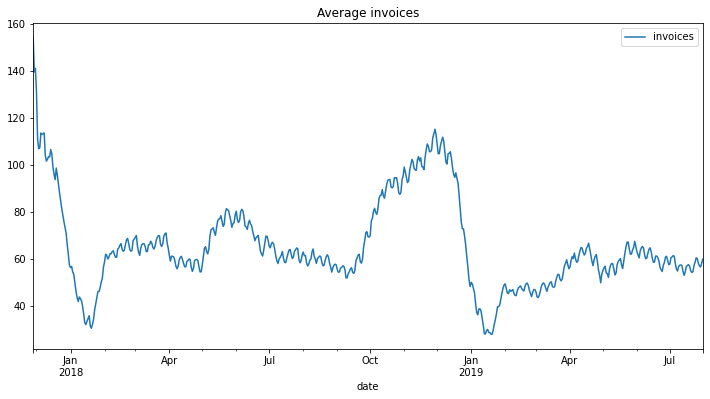

In [108]:
fig, axs = plt.subplots(figsize=(12, 6))
dfn[['invoices']].plot(ax=axs)
plt.title('Average invoices')

Text(0.5, 1.0, 'Average views')

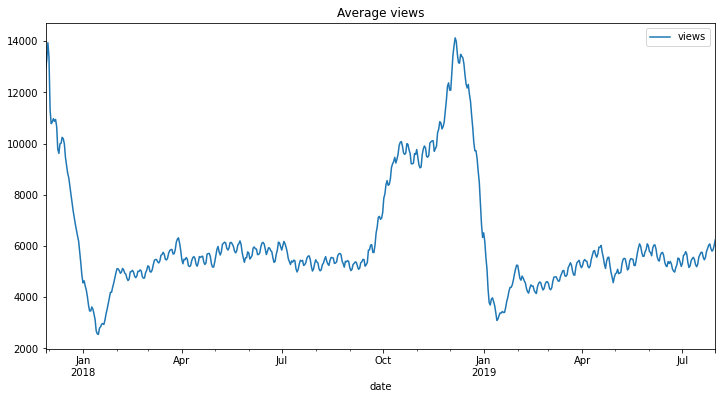

In [109]:
fig, axs = plt.subplots(figsize=(12, 6))
dfn[['views']].plot(ax=axs)
plt.title('Average views')

Text(0.5, 1.0, 'Previous year revenue')

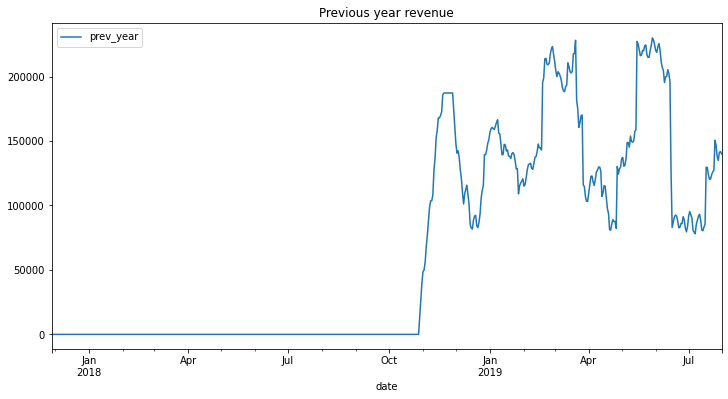

In [110]:
fig, axs = plt.subplots(figsize=(12, 6))
dfn[['prev_year']].plot(ax=axs)
plt.title('Previous year revenue')

## Modelling

Trying out 3 learning algorithms:
- Random Forest
  - Runtime a few seconds: Fast to train as trees are built in parallel, and relatively simple
  - Best Rsquared value (0.92) indicates relatively better correlation between actual and pred
- GBT
  - Runtime a few seconds: Also fast to train
  - Rsquare value (0.89) marginally worse than RF
- MLP
  - As expected, neural networks took longer to converge - 10,000,000 max iterations before it could achieve an Rsquare score of > 0.8
  - Runtime about 15 minutes
  
### Conclusion
Random Forest was picked for the app due to less complexity and decent correlation between actual vs predicted in the test set

In [111]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [202]:
# remove last 30 days from training
dfn_train = dfn.iloc[:-30]

In [203]:
y = dfn_train.pop('revenue')
X = dfn_train

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)

### Random Forest

In [144]:
## train a random forest model
param_grid_rf = {
    'rf__criterion': ['squared_error','absolute_error'],
    'rf__n_estimators': [10,15,20,25]
}

pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                          ('rf', RandomForestRegressor())])

grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=4)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [116]:
print('best score', grid.best_score_)
print('best params', grid.best_params_)

best score 0.8730766160892116
best params {'rf__criterion': 'mae', 'rf__n_estimators': 20}


In [117]:
print('MAE',mean_absolute_error(y_test, y_pred))
print('MSE',mean_squared_error(y_test, y_pred))
print('RMSE',round(np.sqrt(mean_squared_error(y_test,y_pred))))
print('R2', r2_score(y_test, y_pred))

MAE 16067.694680821916
MSE 560462133.4678497
RMSE 23674
R2 0.8908159471234159


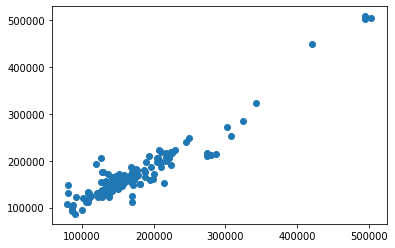

In [118]:
plt.scatter(y_test, y_pred)

### Gradient Boosted Trees

In [145]:
## train a GBT model
param_grid_gbt = {
    'gbt__learning_rate': [0.1,0.01],
    'gbt__n_estimators': [100,150],
    'gbt__max_depth': [2,4,6,8],
    'gbt__subsample': [0.9,0.5,0.2],
}

pipe_gbt = Pipeline(steps=[('scaler', StandardScaler()),
                          ('gbt', GradientBoostingRegressor())])

grid = GridSearchCV(pipe_gbt, param_grid=param_grid_gbt, cv=5, n_jobs=-1, verbose=4)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [120]:
print('best score', grid.best_score_)
print('best params', grid.best_params_)

print('MAE',mean_absolute_error(y_test, y_pred))
print('MSE',mean_squared_error(y_test, y_pred))
print('RMSE',round(np.sqrt(mean_squared_error(y_test,y_pred))))
print('R2', r2_score(y_test, y_pred))

best score 0.8965353549223829
best params {'gbt__learning_rate': 0.1, 'gbt__max_depth': 6, 'gbt__n_estimators': 150, 'gbt__subsample': 0.9}
MAE 14985.78369076113
MSE 542507875.9770808
RMSE 23292
R2 0.894313629628927


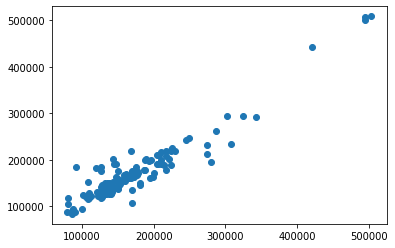

In [121]:
plt.scatter(y_test, y_pred)

### Multilayer Perceptron

In [51]:
## train a MLP model
from sklearn.neural_network import MLPRegressor

pipe_mlp = Pipeline(steps=[('scaler', StandardScaler()),
                          ('mlp', MLPRegressor(random_state=1, max_iter=10000000))])

pipe_mlp.fit(X_train, y_train)
y_pred = pipe_mlp.predict(X_test)

In [52]:
print('MAE',mean_absolute_error(y_test, y_pred))
print('MSE',mean_squared_error(y_test, y_pred))
print('RMSE',round(np.sqrt(mean_squared_error(y_test,y_pred))))
print('R2', r2_score(y_test, y_pred))

MAE 21494.50675248065
MSE 788994825.0098989
RMSE 28089
R2 0.8991818810446791


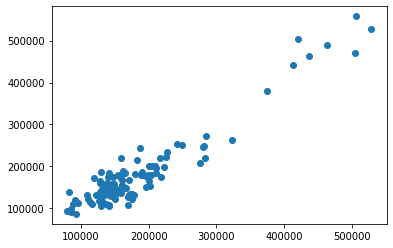

In [53]:
plt.scatter(y_test, y_pred)

## Production Data

Observation and analysis of production data
- Top 10 countries by revenue in production large same except addition of Belgium; Norway dropped out of the top 10
- Results on running prediction production UK data on UK model
  - Unfortunately the model wasn't able to generalize to production data, both R2 and RMSE showed poor correlation

In [151]:
# import and reuse functions from data ingestion library to process production dataset
import datalib

In [146]:
model_path = Path('models') / 'United Kingdom.joblib'
pipe_uk = joblib.load(model_path)

In [149]:
df_prod = datalib.ingest_data(Path('data') / 'cs-production')

C:\Dev\Notebooks\IBM\Capstone\ai-workflow-capstone\datalib.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  df.invoice = df.invoice.str.replace('\D+','')


In [154]:
# top 10 countries by revenue 
df_prod.groupby('country').price.sum().sort_values(ascending=False)[:10]#.index

country
United Kingdom    931655.782
France             26648.170
Germany            18292.630
EIRE               18236.240
Singapore          12305.480
Hong Kong           6504.310
Spain               4498.480
Portugal            3597.170
Belgium             3576.270
Netherlands         3340.430
Name: price, dtype: float64

In [155]:
# compare to top 10 countries in training set
top_countries

Index(['United Kingdom', 'EIRE', 'Germany', 'France', 'Norway', 'Spain',
       'Hong Kong', 'Portugal', 'Singapore', 'Netherlands'],
      dtype='object', name='country')

In [212]:
# use datalib functions to preprocess production data
df_prodt = df_prod[df_prod.country.isin(top_countries)]
df_prod_ts = datalib.process_timeseries(df_prodt, country='United Kingdom')
df_prod_ts = datalib.generate_features(df_prod_ts)

In [213]:
# predict
y_prod = df_prod_ts.pop('revenue')
X_prod = df_prod_ts
y_pred = pipe_uk.predict(X_prod)

In [188]:
print('MAE',mean_absolute_error(y, y_pred))
print('MSE',mean_squared_error(y, y_pred))
print('RMSE',round(np.sqrt(mean_squared_error(y,y_pred))))
print('R2', r2_score(y, y_pred))

MAE 66169.71614375
MSE 6284642683.487259
RMSE 79276
R2 -0.2141882534376096


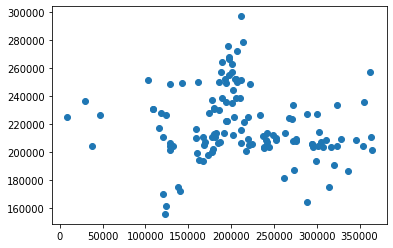

In [181]:
plt.scatter(y, y_pred)

### Performance Monitoring

Predicted vs Actual revenue for production data period

Text(0, 0.5, 'revenue')

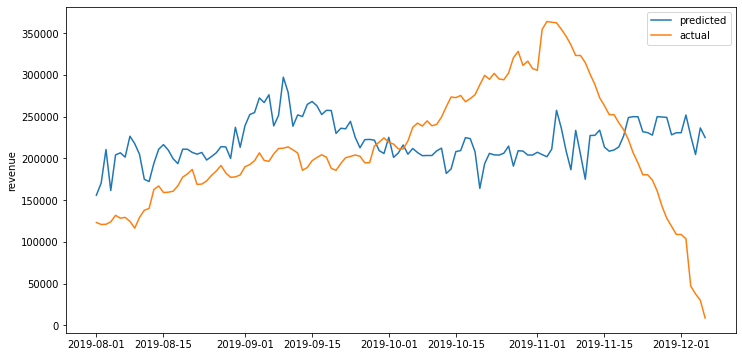

In [189]:
fig, axs = plt.subplots(figsize=(12, 6))
axs.plot(y.index, y_pred, label='predicted')
axs.plot(y, label='actual')
plt.legend()
plt.ylabel('revenue')

## Futher steps
- Explore drift between training input features and production features
- Think of more features to derive that may better capture the seasonality of reveue
- Use more advanced time-series analysis